In [1]:
import os
import random
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats
from sklearn.preprocessing import StandardScaler
import itertools
#from textblob import TextBlob
import scikit_posthocs as sp
import warnings
warnings.filterwarnings('ignore')

Path to directories where data is stored. Set home = 1 for WFH, 0 otherwise.

In [2]:
home = 0
if home:
    infiledir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\Processed_2"
    rand_dir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis"
    
else:
    infiledir = r"P:\EW_analysis\analysis\Processed_2"
    rand_dir = r"P:\EW_analysis\analysis"
    writing_dir = r"P:\EW_analysis\analysis\writing\writing_data"

utils

In [ ]:
def run_gee(in_df,group_name,formula,cov_structure, resp_family):
    """ 
    Run statsmodels GEE.

    Parameters
    ----------
    in_df:  pandas DataFrame
        input dataframe
    group_name: str
        column to group by
    formula:    str
        patsy formula
    cov_structure:  sm covariance structure
        covariance structure (e.g. sm.cov_struct.Independence())
    resp_family:    sm family (e.g. sm.families.Tweedie())
        mean response structure distribution

    Returns
    -------

    """
    model = smf.gee(formula,group_name, in_df, cov_struct = cov_structure, family = resp_family,missing = 'drop').fit()
    qic_df = get_qic_table(in_df,formula,group_name,resp_family)
    
    return model, qic_df
    
def scale_scores(in_df, col_names, scaler_type):
    """ 
    Scale questionnaire scores.

    Parameters
    ----------
    in_df:  pandas Dataframe
        Dataframe to operate on.
    col_names:  list
        list of column names to operate on.
    scaler_type:    scaler to use

    Returns
    -------
    Nothing. Df is mutable, so function will change og df.

    """
    scaler = scaler_type
    for col in col_names:
        in_df[col+'_scaled'] = scaler.fit_transform(in_df[col].values.reshape(-1,1))



# extract numbers from strings
def find_number(text):
    """ 
    Extract numbers from strings

    Parameters
    ----------
    text: str
        input string to operate on
    
    Returns
    -------
    Numerical input string content as string.

    """ 
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)

def get_diaries(directory,filenames,colnames):
    """
    Extract written statements from diary files.

    Parameters
    ----------
    directory:   str
        path to input directory
    filenames:  list
        list of input filenames to operate on
    colnames:   str
        columns to read in from diary files
    """
    pnums = []
    writing = []
    days = []
    for i,name in enumerate(filenames):
        diary_df = pd.read_csv(os.path.join(directory,name),skiprows = [0,2],usecols = colnames)
        diary_df = diary_df.loc[diary_df.Progress==100,:]
        diary_df['day'] = i+1
        pnums.append(diary_df.iloc[:,1])
        writing.append(diary_df.iloc[:,2])
        days.append(diary_df.iloc[:,3])
    return pnums,days,writing

def set_initial_vals(in_df,col_list):
    """ 
    Set values for all assessment time points to session 1 value.

    Parameters
    ----------
    in_df:  pandas DataFrame
        dataframe to operate on
    col_list:   list
        list of columns to operate on

    Returns
    -------
    
    
    """
    sub_ids = in_df.id.unique()
    for pnum in (sub_ids):
        for col in col_list:
            initial_val = in_df.loc[(in_df.id==pnum)&(in_df.order==1),col].iloc[0]
            in_df.loc[(in_df.id==pnum)&(in_df.order.isin([2,3,4])), col] = initial_val
    
    return in_df

    
def demographics_check(in_df, num_subs):
    """ 
    Basic demographics check.

    Parameters
    ----------
    in_df:  pandas DataFrame
        input dataframe to operate on
    num_subs:   int
        number of subjects
    
    Returns
    -------
        DataFrame of %age of sample in demographic categories.
    """
    demographics_df = in_df.filter(like = 'Selected Choice', axis = 1)
    sex = demographics_df.filter(like = 'your sex',axis = 1).value_counts()/num_subs
    ethnicity = demographics_df.filter(like = 'your ethnic group',axis = 1).value_counts()/num_subs
    education = demographics_df.filter(like = 'education',axis = 1).value_counts()/num_subs
    working = demographics_df.filter(like = 'working',axis = 1).value_counts()/num_subs

    op_df = pd.DataFrame({'sex': sex, 'ethnicity':ethnicity,'education':education,'working':working})
    return (op_df)*100
    
class Data_Explorer:
    def __init__(self, response_var):
        self.response_name = response_var
    
    def nan_ids(self,in_df):
        self.response_vals = in_df[self.response_name]
        self.nan_ids = in_df.loc[in_df[self.response_name].isna(),'id'].values
    
    def zero_ids(self, in_df):
        self.zero_ids = in_df.loc[in_df[self.response_name]==0, 'id'].unique()
        self.zero_groups = in_df.loc[in_df.id.isin(self.zero_ids),'Group'].value_counts()
    
    
    def visualize_dist(self, distribution = None):
        if not distribution:
            self.distribution = 'normal'
        else:
            self.distribution = distribution


        if self.distribution == 'normal':
            fig = sm.qqplot(self.response_vals,line = 'q')
            fig.show()
        else:
            fig = sm.qqplot(self.response_vals,dist = stats.gamma,distargs = (4,),line = 'q')
            fig.show()
    
    def draw_kdeplot(self,in_df,names,colors):
        for i,session in enumerate(in_df.order.unique()):
            fig = sns.kdeplot(all_dat_df.loc[in_df.order == session, self.response_name],color = colors[i] )
        plt.legend(names)
    
    def draw_mean_trajectories(self,in_df):
        fig_mean, ax = plt.subplots(figsize=(6, 6))
        fig_mean = interaction_plot(
        x=in_df.time,
        trace=in_df.Group,
        response=in_df[self.response_name],
        colors=["red", "blue","black"],
        markers=["D", "^",'x'],
        ms=10,
        ax=ax,
        )
               
def get_qic_table(data_df, formula, group, family_name):
    """ 
    Compare models with different covariance structures, based on QIC.

    Parameters
    ----------
    data_df:    pandas DataFrame
        input dataframe
    formula:    str
        statsmodels GEE formula (patsy)
    group:  str
        column to group by
    family_name:    str
        mean response structure name
    
    Returns
    -------
        Pandas DataFrame containing qic values for each model.
    """
    model_covi = smf.gee(formula,group, data_df, cov_struct = sm.cov_struct.Independence(), family = family_name,missing = 'drop').fit()
    model_covx = smf.gee(formula,group, data_df, cov_struct = sm.cov_struct.Exchangeable(), family = family_name,missing = 'drop').fit()
    model_covar = smf.gee(formula,group, data_df, cov_struct = sm.cov_struct.Autoregressive(), family = family_name,missing = 'drop').fit()
    out_df = pd.DataFrame({'dependency type': ['Independence','Exchangeable','Autoregressive'], 'QIC': [model_covi.qic()[0], model_covx.qic()[0],model_covar.qic()[0]], 'QICu': [model_covi.qic()[1], model_covx.qic()[1],model_covar.qic()[1]]})
    return out_df

# simulate some data for the prediction (mean +/- 1 std)
def simulate_to_predict(dat_vals):
    dat_sim = []
    mu = dat_vals.mean()
    std = dat_vals.std()
    for i in range(0,len(dat_vals)):
        value = random.gauss(mu,std)
        if value>mu+std:
            value == mu+std
        elif value<mu-std:
            value == mu-std
        dat_sim.append(value)
    return dat_sim

def model_checks(data_df, columns_to_use, y_to_use,GEE_res):
    """
    Model diagnostics

    Parameters
    ----------
    data_df:    pandas DataFrame
        input dataframe
    columns_to_use: str
        names of columns containing predictors to be used in the analysis
    y_to_use:   str
        names of outcome column
    GEE_res:    
        GEE model results

    -------
    """
    gee_res_df = data_df.loc[:,columns_to_use]
    drop_inds = gee_res_df.loc[gee_res_df[y_to_use].isna(),:].index.values
    gee_res_df = gee_res_df.drop(labels = drop_inds, axis = 0)
    gee_res_df['resid_dev'] = GEE_res.resid_deviance
    gee_res_df['fitted'] = GEE_res.fittedvalues
    a = GEE_res.resid_deviance
    a.sort()
    fig = plt.figure()
    res = stats.probplot(a,dist = stats.halfnorm,sparams = (-0.18,10), plot=plt)
    plt.show()
    # plotting fitted agains residuals
    g = sns.lmplot(x = "fitted", y = "resid_dev", hue = "Group", data = gee_res_df)
    g = (g.set_axis_labels("Predicted score", "Deviance residuals"))#.set(xlim=(42, 55)))
    g = sns.lmplot(x = "time", y = "resid_dev", hue = "Group", data = gee_res_df)
    g = (g.set_axis_labels("Time [Weeks]", "Deviance residuals").set(xlim=(-1, 14)))

# function to calculate cluster cook statisticts. Doesn't work as intended though so not used. Couldn't find the bug???
def cooks_d(data_df, formula_to_use, group_to_use, cov_structure, resp_family, orig_GEE_res,num_params):
    cooks_dist = []
    all_ids = []
    for i,pnum in enumerate(data_df.id.unique()):
        # eliminate id from dataframe
        red_df = data_df.drop(labels = data_df.loc[data_df.id == pnum].index.values,axis = 0)
        # fit model
        model_red = smf.gee(formula_to_use,group_to_use, red_df, cov_struct = cov_structure, family = resp_family,missing = 'drop').fit()
        # get coefficients
        #drops = list(orig_GEE_res.fittedvalues.index.values)
        #droplabels = np.array([f for f in drops if f not in list(model_red.fittedvalues.index.values)])
        diff_full = abs(orig_GEE_res.fittedvalues-model_red.fittedvalues)
        cooks_d = np.sum(np.square(diff_full))/(num_params*np.mean(np.square(orig_GEE_res.resid_deviance)))
        cooks_dist.append(cooks_d)
        all_ids.append(pnum)
    cooks_distance_df = pd.DataFrame({'id':all_ids,'cooks_distance':cooks_dist})
    return cooks_distance_df

Load the qualtrics data and add columns for time in weeks and whether or not the same event was reported in the ADNM-20. The latter is done by checking the sequence matcher and spacy based scores against a pre-set threshold.

In [6]:
all_dat_df = pd.read_csv(os.path.join(infiledir, 'all_dat_df.csv')) # read in data
# column to denote whether or not they reported the same stressful events for the ADNM-20 at each time point
all_dat_df['same_event'] = 0
# if spacy version suggests >0.8 similarity, set to 1 (inspection showed that this seems to be a reasonable cut-off.)
all_dat_df.loc[all_dat_df.most_stressful_similarity2>0.8,'same_event'] = 1
all_dat_df.loc[(all_dat_df.most_stressful_similarity>0.2)&(all_dat_df.most_stressful_similarity2<0.8),'same_event'] = 1 # also set to 1 if spacy is below the cut-off, but SequenceMatcher is higher than 0.2 (based on visual inspection)
all_dat_df.loc[(all_dat_df.order==1),'same_event']=np.nan

all_dat_df['time'] = all_dat_df.order
all_dat_df.loc[all_dat_df.order==1,'time'] = 0
all_dat_df.loc[all_dat_df.order==2,'time'] = 2
all_dat_df.loc[all_dat_df.order==3,'time'] = 4
all_dat_df.loc[all_dat_df.order==4,'time'] = 12

scale_scores(all_dat_df,['ERQ_reapp','ERQ_sup','RRS_total','ADNM_burden_total'],StandardScaler())


In [7]:
# set ERQ and RRS values to session 1 vals.
all_dat_df = set_initial_vals(all_dat_df, ['ERQ_reapp','ERQ_sup','RRS_total'])
# check demographics.
num_subs = len(all_dat_df.id.unique())
demographics_sum = demographics_check(all_dat_df, num_subs)

We've now got to find participant ages. These are in the screening data file, which does not have participant numbers, only screening ids. We therefore have to match the screening ids to the participant numbers via the randomisation file.

In [8]:
screening_df = pd.read_csv(os.path.join(rand_dir, 'screening_data.csv'),skiprows = [0,2],usecols = ['Please enter the last four digits of your phone number','Please enter your age.'])
rand_df = pd.read_csv(os.path.join(rand_dir,'randomisation.csv'))
rand_df.loc[:,'Screening Id'] = rand_df['Screening Id'].apply(find_number).astype('int')
screening_df = screening_df.loc[screening_df['Please enter the last four digits of your phone number'].isin(rand_df['Screening Id']),:]
screening_df['id'] = rand_df.loc[rand_df['Screening Id'].isin(screening_df['Please enter the last four digits of your phone number']),'Participant number'].apply(find_number).astype('int')
print("The mean age was", screening_df.loc[screening_df.id.isin(all_dat_df.id),'Please enter your age.'].mean())
print("Std was", screening_df.loc[screening_df.id.isin(all_dat_df.id),'Please enter your age.'].std())
print("The range was: ", screening_df.loc[screening_df.id.isin(all_dat_df.id),'Please enter your age.'].min(), screening_df.loc[screening_df.id.isin(all_dat_df.id),'Please enter your age.'].max())

The mean age was 28.104166666666668
Std was 4.727644293659992
The range was:  20.0 37.0


We'll do some basic checks on the writing to get an idea of whether participants adhered to the instructions.

In [9]:

# read in files from directory
writing_dir = r"P:\EW_analysis\analysis\writing\writing_data"
writing_files = [f for f in os.listdir(writing_dir) if 'Writing' in f]

ids,days,writing = get_diaries(writing_dir,[f for f in writing_files if 'T1 in f'],[4,18,23])
ew_frame= pd.DataFrame({'id':pd.Series(list(itertools.chain.from_iterable(ids))),'writing': pd.Series(list(itertools.chain.from_iterable(writing))),'days':pd.Series(list(itertools.chain.from_iterable(days)))})
ids,days,writing = get_diaries(writing_dir,[f for f in writing_files if 'T2' in f],[4,18,23])
ewre_frame = pd.DataFrame({'id':pd.Series(list(itertools.chain.from_iterable(ids))),'writing': pd.Series(list(itertools.chain.from_iterable(writing))),'days':pd.Series(list(itertools.chain.from_iterable(days)))})
ids,days,writing = get_diaries(writing_dir,[f for f in writing_files if 'T3 in f'],[4,18,23])
ctr_frame = pd.DataFrame({'id':pd.Series(list(itertools.chain.from_iterable(ids))),'writing': pd.Series(list(itertools.chain.from_iterable(writing))),'days':pd.Series(list(itertools.chain.from_iterable(days)))})

# now let's check word counts for each condition.
ew_frame['word_count'] = ew_frame.writing.astype('str').str.split().apply(len)
ewre_frame['word_count'] = ewre_frame.writing.astype('str').str.split().apply(len)
ctr_frame['word_count'] = ctr_frame.writing.astype('str').str.split().apply(len)

# now to get the word count for each day and condition
print("EW:", ew_frame.groupby('days').word_count.mean())
print("EWRE:", ewre_frame.groupby('days').word_count.mean())
print("CTR:", ctr_frame.groupby('days').word_count.mean())

stat, pval = stats.f_oneway(ew_frame.groupby('days').word_count.mean(),ewre_frame.groupby('days').word_count.mean(),ctr_frame.groupby('days').word_count.mean())
print('Word count different between groups when ordered by day - F: {}, p: {}'.format(stat,pval))
stat, pval = stats.f_oneway(ew_frame.word_count,ewre_frame.word_count,ctr_frame.word_count) # check if word count is significantly different between the different conditions
print('Word count different between groups - F: {}, pval {}'.format(stat,pval))

EW: days
1     568.536585
2     510.450000
3     488.641026
4     470.076923
5     613.902439
6     575.463415
7     508.675000
8     491.900000
9     551.300000
10    443.750000
11    372.500000
12    423.675000
Name: word_count, dtype: float64
EWRE: days
1    613.902439
2    575.463415
3    508.675000
4    491.900000
Name: word_count, dtype: float64
CTR: days
1     568.536585
2     510.450000
3     488.641026
4     470.076923
5     613.902439
6     575.463415
7     508.675000
8     491.900000
9     551.300000
10    443.750000
11    372.500000
12    423.675000
Name: word_count, dtype: float64
Word count different between groups when ordered by day - F: 0.7871813598374434, p: 0.46608419610436835
Word count different between groups - F: 2.130240177552403, pval 0.11928946000280186


We'll use TextBlob to get some basic subjectivity and polarity scores for each group.

In [ ]:
ew_frame['Group'] = 'EW'
ewre_frame['Group'] = 'EWRE'
ctr_frame['Group'] = 'CTR'
writing_df = pd.concat([ew_frame,ewre_frame,ctr_frame]).reset_index()
writing_df['sentiment'] = writing_df.writing.astype('str').apply([lambda x: TextBlob(x)])
writing_df['polarity'] = writing_df.sentiment.apply([lambda x: x.sentiment.polarity])
writing_df['subjectivity'] = writing_df.sentiment.apply([lambda x: x.sentiment.subjectivity])

Data exploration


Displaying results...

Outcome: ADNM_burden_total
There are 11 zeros in response variable ADNM_burden_total.
There are 4 NaNs in response variable ADNM_burden_total.

Displaying results...

Outcome: dass_depression
There are 17 zeros in response variable dass_depression.
There are 0 NaNs in response variable dass_depression.

Displaying results...

Outcome: dass_anxiety
There are 39 zeros in response variable dass_anxiety.
There are 0 NaNs in response variable dass_anxiety.

Displaying results...

Outcome: dass_stress
There are 16 zeros in response variable dass_stress.
There are 0 NaNs in response variable dass_stress.


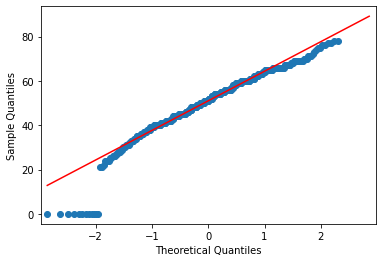

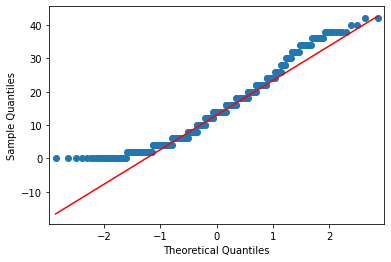

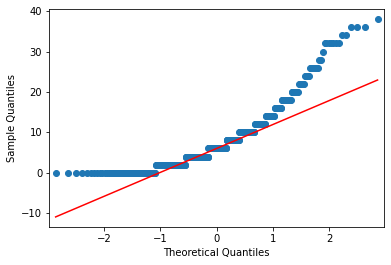

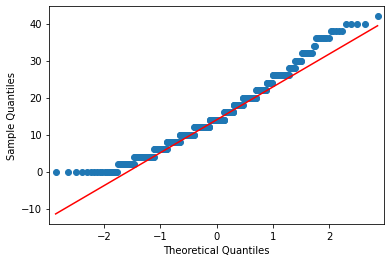

In [20]:
for outcome in ['ADNM_burden_total','dass_depression','dass_anxiety','dass_stress']:
    print('\nDisplaying results...\n')
    dt = Data_Explorer(outcome)
    dt.nan_ids(all_dat_df)
    dt.zero_ids(all_dat_df)
    print('Outcome: {}'.format(dt.response_name))
    print(f'There are {len(dt.zero_ids)} zeros in response variable {dt.response_name}.')
    print(f'There are {len(dt.nan_ids)} NaNs in response variable {dt.response_name}.')

    dt.visualize_dist()

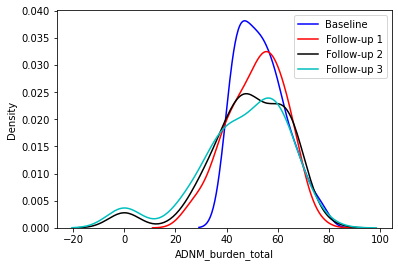

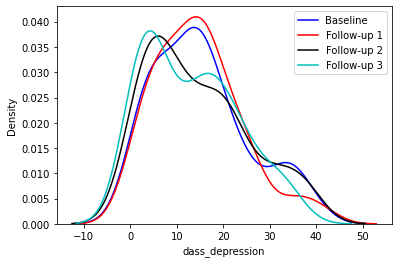

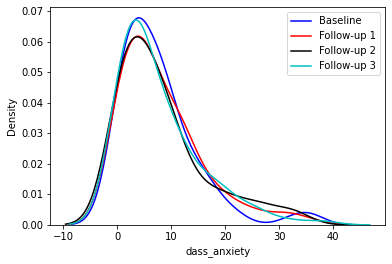

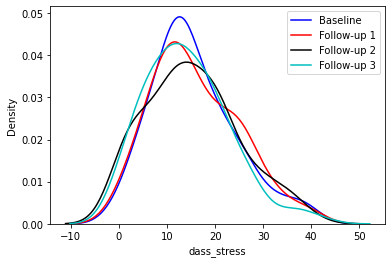

In [21]:
for i,outcome in enumerate(['ADNM_burden_total','dass_depression','dass_anxiety','dass_stress']):
    dt = Data_Explorer(outcome)
    colors = ['b','r','k','c']
    names = ['Baseline','Follow-up 1', 'Follow-up 2','Follow-up 3']
    plt.figure(i)
    dt.draw_kdeplot(all_dat_df,names, colors)

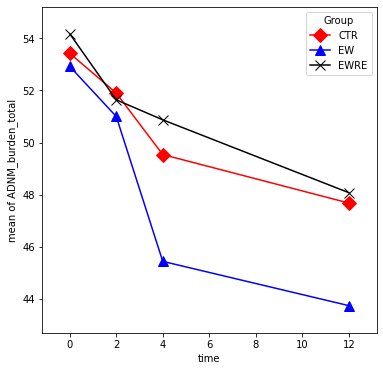

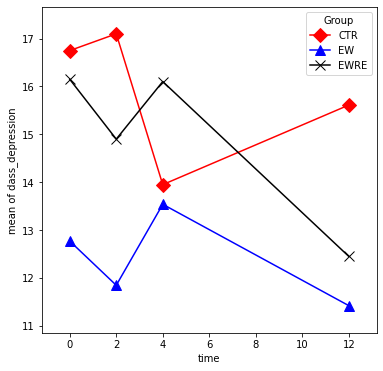

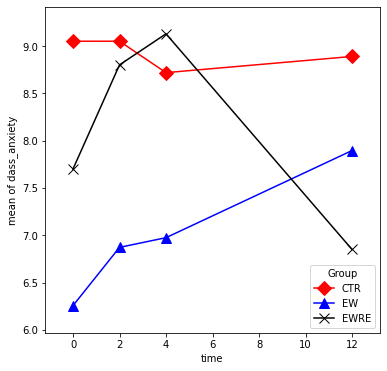

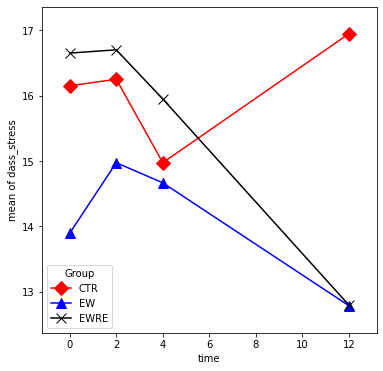

In [22]:
for outcome in ['ADNM_burden_total','dass_depression','dass_anxiety','dass_stress']:
    dt = Data_Explorer(outcome)
    dt.draw_mean_trajectories(all_dat_df)

In [126]:
# check whether scores are significantly different at baseline
for i, outcome in enumerate(['ADNM_burden_total', 'dass_depression', 'dass_anxiety', 'dass_stress', 'ERQ_reapp','ERQ_sup','RRS_total']):
    data = [all_dat_df.loc[(all_dat_df.Group.isin(['EW','EWRE']))&(all_dat_df.time == 0),outcome].dropna().values,all_dat_df.loc[(all_dat_df.Group == 'CTR') &(all_dat_df.time ==0),outcome].dropna().values]
    print('Outcome:{},\nstats: {}\n'.format(outcome, stats.kruskal(data[0],data[1])))
    print('Posthoc:\n1 = EW, 3 = CTR\n {}\n'.format(sp.posthoc_dunn(data, p_adjust = 'bonferroni')))

Outcome:ADNM_burden_total,
stats: KruskalResult(statistic=0.17369314944962796, pvalue=0.6768502313466718)

Posthoc:
1 = EW, 3 = CTR
          1        2
1  1.00000  0.67685
2  0.67685  1.00000

Outcome:dass_depression,
stats: KruskalResult(statistic=1.7127808379438691, pvalue=0.19062496815948377)

Posthoc:
1 = EW, 3 = CTR
           1         2
1  1.000000  0.190625
2  0.190625  1.000000

Outcome:dass_anxiety,
stats: KruskalResult(statistic=2.299515648489076, pvalue=0.12941434884273248)

Posthoc:
1 = EW, 3 = CTR
           1         2
1  1.000000  0.129414
2  0.129414  1.000000

Outcome:dass_stress,
stats: KruskalResult(statistic=0.06459009406178311, pvalue=0.79938291162651)

Posthoc:
1 = EW, 3 = CTR
           1         2
1  1.000000  0.799383
2  0.799383  1.000000

Outcome:ERQ_reapp,
stats: KruskalResult(statistic=2.790688296593056, pvalue=0.094813494934288)

Posthoc:
1 = EW, 3 = CTR
           1         2
1  1.000000  0.094813
2  0.094813  1.000000

Outcome:ERQ_sup,
stats: KruskalRe

In [317]:
# get simulated data & prepare a dataframe for the analysis below.
ERQ_sim = simulate_to_predict(all_dat_df.ERQ_reapp)
model_df = pd.DataFrame({'id':all_dat_df.id,'time':all_dat_df.time,'Group':all_dat_df.Group})
model_df['ERQ_reapp_scaled'] = StandardScaler().fit_transform(np.array(ERQ_sim).reshape(-1,1))
ERQ_sup_sim = simulate_to_predict(all_dat_df.ERQ_sup)
model_df['ERQ_sup_scaled'] = StandardScaler().fit_transform(np.array(ERQ_sup_sim).reshape(-1,1))
RRS_sim = simulate_to_predict(all_dat_df.RRS_total)
model_df['RRS_scaled'] = StandardScaler().fit_transform(np.array(RRS_sim).reshape(-1,1))

ADNM 20 scores - analysis

Because the active groups did not differ significantly in terms of their writing, we will treat them as one group.

In [11]:
# combine the two active groups into a single group.
all_dat_df['Group_act_v_ctr'] = all_dat_df.Group.replace('EWRE','EW')
all_dat_df.groupby('time').Group_act_v_ctr.value_counts()

time  Group_act_v_ctr
0.0   EW                 79
      CTR                40
2.0   EW                 79
      CTR                40
4.0   EW                 78
      CTR                39
12.0  EW                 78
      CTR                36
Name: Group_act_v_ctr, dtype: int64

In [29]:
all_dat_df.loc[(all_dat_df.order == 1),'same_event'] = 1
all_ids = []
for pnum in all_dat_df.id.unique():
    if all_dat_df.loc[all_dat_df['id']==pnum,'same_event'].sum()==4:
        all_ids.append(pnum)
    else:
        continue
all_dat_df['all_same'] = 0
all_dat_df.loc[all_dat_df.id.isin(all_ids),'all_same'] = 1

In [46]:
model_tweedie_adnm, adnm_qic_df = run_gee(all_dat_df,"id","ADNM_burden_total ~ C(time) * C(Group_act_v_ctr,Treatment('CTR'))", sm.cov_struct.Autoregressive(), sm.families.Tweedie())
model_adnm_chron, chron_qic_df = run_gee(all_dat_df,"id","ADNM_burden_total ~ C(time) * C(Group_act_v_ctr,Treatment('CTR'))*all_same", sm.cov_struct.Autoregressive(), sm.families.Tweedie())
model_adnm_ERQ_reapp, erqreapp_qic_df = run_gee(all_dat_df,"id","ADNM_burden_total ~ C(time) * C(Group_act_v_ctr,Treatment('CTR')) * ERQ_reapp_scaled", sm.cov_struct.Autoregressive(), sm.families.Tweedie())
model_adnm_ERQ_sup, erqsup_qic_df = run_gee(all_dat_df,"id","ADNM_burden_total ~ C(time) * C(Group_act_v_ctr,Treatment('CTR')) * ERQ_sup_scaled", sm.cov_struct.Autoregressive(), sm.families.Tweedie())
model_adnm_RRS, rrs_qic_df = run_gee(all_dat_df,"id","ADNM_burden_total ~ C(time) * C(Group_act_v_ctr,Treatment('CTR'))*RRS_total_scaled", sm.cov_struct.Autoregressive(), sm.families.Tweedie())

In [76]:
for model in ([model_adnm_ERQ_reapp, model_adnm_ERQ_sup, model_adnm_RRS]):
    print(model_tweedie_adnm.qic(), model.qic())

(1408.318685834102, 618.2426596766588) (2067.1039250334948, 626.5885032632312)
(1408.318685834102, 618.2426596766588) (1869.8953272041724, 622.8447252955032)
(1408.318685834102, 618.2426596766588) (2165.839194170414, 634.1384973383674)


In [51]:
model_adnm_ERQ_sup.pvalues

Intercept                                                                    0.000000
C(time)[T.2.0]                                                               0.281992
C(time)[T.4.0]                                                               0.295124
C(time)[T.12.0]                                                              0.114541
C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                                   0.881495
C(time)[T.2.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                    0.698764
C(time)[T.4.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                    0.384338
C(time)[T.12.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                   0.565640
ERQ_sup_scaled                                                               0.558065
C(time)[T.2.0]:ERQ_sup_scaled                                                0.410433
C(time)[T.4.0]:ERQ_sup_scaled                                                0.007834
C(time)[T.12.0]:ERQ_sup_scaled                        

Some basic model checks

Plotting fitted against residuals. Note that residuals need not be normally distributed for GEEs. We are looking for two main things:
(i) Are there any obvious non-linearities?
(ii) Inspect the variance of the residuals with respect to the fitted values. Look for non-constant variance, which would require a change in the model.
Heree things look decent apart from the obvs outlier.

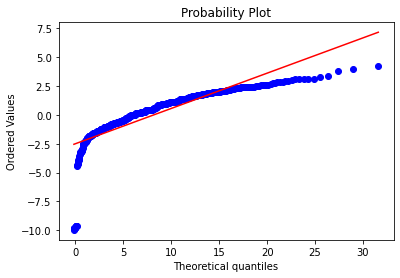

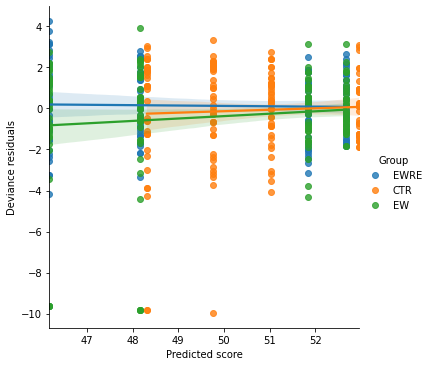

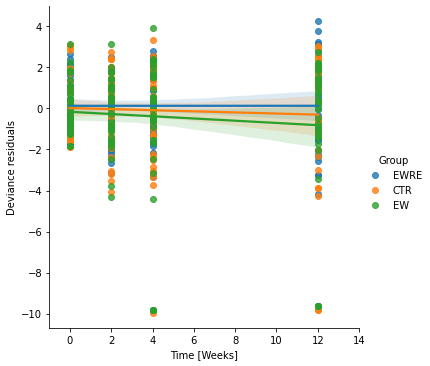

In [52]:
model_checks(all_dat_df,['ADNM_burden_total','id','time','Group'],'ADNM_burden_total',model_tweedie_adnm)

DASS subscales

In [54]:
model_tweedie_dassd, dassd_qic_df = run_gee(all_dat_df,"id","dass_depression ~ C(time) * C(Group_act_v_ctr,Treatment('CTR'))", sm.cov_struct.Autoregressive(), sm.families.Tweedie())
model_dassd_ERQ_reapp, dassd_erqreapp_qic_df = run_gee(all_dat_df,"id","dass_depression ~ C(time) * C(Group_act_v_ctr,Treatment('CTR')) * ERQ_reapp_scaled", sm.cov_struct.Autoregressive(), sm.families.Tweedie())
model_dassd_ERQ_sup, dassd_erqsup_qic_df = run_gee(all_dat_df,"id","dass_depression ~ C(time) * C(Group_act_v_ctr,Treatment('CTR')) * ERQ_sup_scaled", sm.cov_struct.Autoregressive(), sm.families.Tweedie())
model_dassd_RRS, dassd_rrs_qic_df = run_gee(all_dat_df,"id","dass_depression ~ C(time) * C(Group_act_v_ctr,Treatment('CTR'))*RRS_total_scaled", sm.cov_struct.Autoregressive(), sm.families.Tweedie())

In [75]:
for model in ([model_dassd_ERQ_reapp, model_dassd_ERQ_sup, model_dassd_RRS]):
    print(model_tweedie_dassd.qic(), model.qic())

(725.8097710609309, 508.65779162565) (864.9704686175062, 507.1373128057284)
(725.8097710609309, 508.65779162565) (882.1673621992137, 514.1610370541848)
(725.8097710609309, 508.65779162565) (933.128147974566, 506.847371812287)


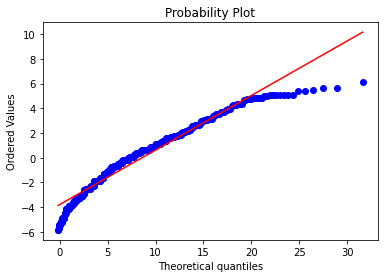

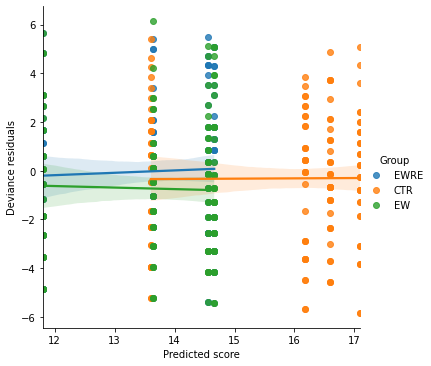

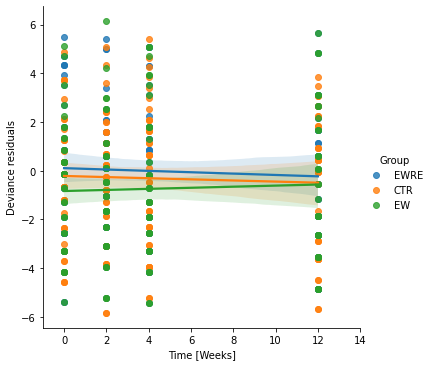

In [55]:
model_checks(all_dat_df,['dass_depression','id','time','Group'],'dass_depression',model_tweedie_dassd)

DASS anxiety

In [ ]:
model_tweedie_dassa, dassa_qic_df = run_gee(all_dat_df,"id","dass_anxiety ~ C(time) * C(Group_act_v_ctr,Treatment('CTR'))", sm.cov_struct.Autoregressive(), sm.families.Tweedie())
model_dassa_ERQ_reapp, dassa_erqreapp_qic_df = run_gee(all_dat_df,"id","dass_anxiety ~ C(time) * C(Group_act_v_ctr,Treatment('CTR')) * ERQ_reapp_scaled", sm.cov_struct.Autoregressive(), sm.families.Tweedie())
#model_dassa_ERQ_sup, dassa_erqsup_qic_df = run_gee(all_dat_df,"id","dass_anxiety ~ C(time) * C(Group_act_v_ctr,Treatment('CTR')) * ERQ_sup_scaled", sm.cov_struct.Independence(), sm.families.Tweedie())
model_dassa_RRS, dassa_rrs_qic_df = run_gee(all_dat_df,"id","dass_anxiety ~ C(time) * C(Group_act_v_ctr,Treatment('CTR'))*RRS_total_scaled", sm.cov_struct.Autoregressive(), sm.families.Tweedie())

In [74]:
for model in ([model_dassa_ERQ_reapp, model_dassa_RRS]):
    print(model_tweedie_dassa.qic(), model.qic())

(565.9033415699311, 447.8202311774023) (623.8677415810237, 456.847946703381)
(565.9033415699311, 447.8202311774023) (688.063065116622, 474.22716272391654)


DASS stress

In [68]:
model_tweedie_dasss, dasss_qic_df = run_gee(all_dat_df,"id","dass_stress ~ C(time) * C(Group_act_v_ctr,Treatment('CTR'))", sm.cov_struct.Autoregressive(), sm.families.Tweedie())
model_dasss_ERQ_reapp, dasss_erqreapp_qic_df = run_gee(all_dat_df,"id","dass_stress ~ C(time) * C(Group_act_v_ctr,Treatment('CTR')) * ERQ_reapp_scaled", sm.cov_struct.Autoregressive(), sm.families.Tweedie())
model_dasss_ERQ_sup, dasss_erqsup_qic_df = run_gee(all_dat_df,"id","dass_stress ~ C(time) * C(Group_act_v_ctr,Treatment('CTR')) * ERQ_sup_scaled", sm.cov_struct.Independence(), sm.families.Tweedie())
model_dasss_RRS, dasss_rrs_qic_df = run_gee(all_dat_df,"id","dass_stress ~ C(time) * C(Group_act_v_ctr,Treatment('CTR'))*RRS_total_scaled", sm.cov_struct.Autoregressive(), sm.families.Tweedie())

In [71]:
for model in ([model_dasss_ERQ_reapp, model_dasss_ERQ_sup, model_dasss_RRS]):
    print(model_tweedie_dasss.qic(), model.qic())

(762.0709058203729, 519.805602668469) (926.2084287279944, 526.2120835901509)
(762.0709058203729, 519.805602668469) (957.4993477934565, 523.7179144574175)
(762.0709058203729, 519.805602668469) (981.6045297098317, 536.5196481532365)


In [ ]:
model_checks(all_dat_df,['dass_stress','id','time','Group'],'dass_stress',model_tweedie_dasss)